#### 本次成绩:65

### 评卷标准:
- 分析，理顺，项目要求并落实在文档中   √
- 比较不同结果 ，思考，改进，总结。   √
- 成绩提交并截图成绩   ？
- 最终结论，报告。    ？

看得出完成这个作业，是不容易的。和那些基础好，学习能力强的同学相比，已经是很不容易 了。继续坚持下去

#### 评卷：David

本文的主要思想是：
1）先看看数据的样子，是否有空缺值，数据的类型除了数值型，是否还有其他类型？
    如果有空缺值分组填充，数值型的空缺值，则填均值，非空缺填none;
    对于非数值的特征需要采用编码方式将其表示成向量的形式；
    当然如果能提前删除以下不需要的特征，则在计算速度和数据处理上都是不错的，所以接下来通过一些EDA的统计方法探寻特征与目标之间的关系；   
2）先使用EDA的统计方法，对目标函数进行统计分析。并做相关性检测，筛选掉一些特征。
    通过目标函数的分布概率图可以看出，形状类似于正态分布，因此会用标准正态分布拟合target数据。通过skew函数看拟合的偏离情况，发现偏离结果为1.88，通过查资料发现，可以通过两种方式解决上述情形，一种方式是分析特征之间的相关性，找更有用的特征；另一种方式的替换变量。本文采用的是替换变量。这样拟合比较好的结果，用于特征与替换后的变量做相关性等操作。
3）填空缺值
4）使用三种模型做融合，可以到数据集的大小，数据的稀疏性，特征的离散型等因素选择了鲁棒性和抗过拟合能力都很强的随机森林，xgboost，岭回归（参考别人的kernal）.然后对这些模型的进行融合，使用网格搜索交叉验证的方式寻找最优模型，及参数。评价指标，我采用看R2,cv_score两种。
5）模型融合，是权值的融合。这里构造了一个函数来确定选择各个模型的比例是多少。这个函数是求解三个模型预测均方误差的和值，加入L2正则化，可以采用随机梯度下降优化权值。（这一步由于时间原因，代码没写完，接下来的有的做了，有的思路，但目前还没做。）
6）可以对特征值的重要度进行排序，我做了，采用的是对最优化随机森林这个模型的特征重要度排序，我发现有一定数据的特征对结果的贡献度为0，这样的话，是可以筛选的。另外，通过四则运算组合重要度排在前几名的的特征，产生一些新的有价值的特征，也可以通过其他方式等，再运行一次模型，看看结果如何。
7）其实也可以通过迁徙学习处理该问题。LSTM，DNN等模型均可。
8）可以通过调参优化模型。

In [3]:
# importing Python libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew

In [4]:
# Input data files are available in the "../input/" directory.
import os
print(os.listdir("../zhaoqi"))
# Any results written to the current directory are saved as output.

['train.csv', '.ipynb_checkpoints', 'test.csv', 'houseprice1.ipynb', 'sample_submission.csv']


In [5]:
# importing the supplied dataset and storing it in a dataframe
training = pd.read_csv('../zhaoqi/train.csv')
test = pd.read_csv('../zhaoqi/test.csv')
# making copies of original datasets for rest of this kernel
df_train = training.copy()
df_test = test.copy()

In [6]:
target = df_train['SalePrice']  #target variable
df_train = df_train.drop('SalePrice', axis=1) #drop target variable from training dataset
df_train['training_set'] = True #assing an extra variable to training and testing dataset before joining them
df_test['training_set'] = False
df_full = pd.concat([df_train, df_test]) #concatenate both dataframes prior to EDA

In [7]:
df_full.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,training_set
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,True
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,True
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,True
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,True
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,True


In [8]:
df_full.info()#可以看出有不少值为空，有多种不同的数据类型.可以在填缺失值时，按照数据类型填

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-

In [9]:
df_full.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
Alley            2721
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
MasVnrArea         23
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         1
TotRmsAbvGrd        0
Functional          2
Fireplaces          0
FireplaceQu      1420
GarageType        157
GarageYrBlt       159
GarageFinish      159
GarageCars          1
GarageArea          1
GarageQual        159
GarageCond        159
PavedDrive

In [10]:
df_full.columns[df_full.isnull().sum()>200]

Index([u'LotFrontage', u'Alley', u'FireplaceQu', u'PoolQC', u'Fence',
       u'MiscFeature'],
      dtype='object')

In [11]:
df_full.drop(df_full.columns[df_full.isnull().sum()>200],axis=1,inplace=True)
#df_full.drop('Id',axis=1,inplace=True)

In [12]:
df_full.shape#将缺失值较高的列删除了，其实直接删除的话，对后面的数据处理稍简单些，但是有可能会丢失数据，这一点需要注意。

(2919, 75)

现在看看目标函数的样子，以及统计特征

In [13]:
print("There are {} NA values in 'SalePrice'".format(target.isnull().values.sum()))

There are 0 NA values in 'SalePrice'


In [14]:
# let's get some stats on the 'SalePrice' variable
minimum_price = np.min(target)
maximum_price = np.max(target)
mean_price = np.mean(target)
median_price = np.median(target)
std_price = np.std(target)

# Show the calculated statistics
print("Statistics for the supplied house prices training dataset:")
print("Minimum price: ${:,.2f}".format(minimum_price))
print("Maximum price: ${:,.2f}".format(maximum_price))
print("Mean price: ${:,.2f}".format(mean_price))
print("Median price ${:,.2f}".format(median_price))
print("Standard deviation of prices: ${:,.2f}".format(std_price))

Statistics for the supplied house prices training dataset:
Minimum price: $34,900.00
Maximum price: $755,000.00
Mean price: $180,921.20
Median price $163,000.00
Standard deviation of prices: $79,415.29


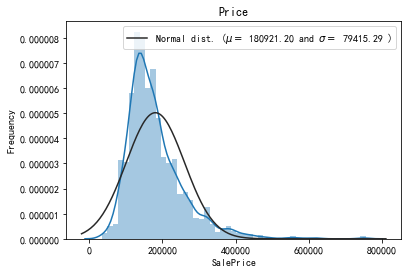

In [15]:
sns.distplot(target , fit=norm);
# get mean and standard deviation
(mu, sigma) = norm.fit(target)#拟合出最好的参数
# add legends to the plot
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price');

In [16]:
target.skew()

1.8828757597682129

In [17]:
#上图中的偏差，对于这种情况有两种方法，一种是去除异常值的方式；另一种是转换变量方式。对于异常值处理，无法有一个评价指标判断

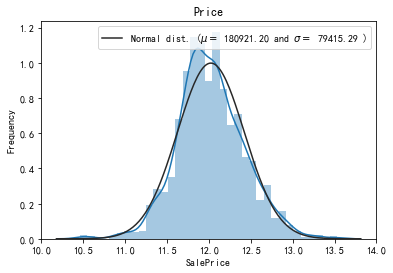

In [18]:
target1 = np.log(target)
sns.distplot(target1, fit=norm)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price');

In [19]:
target1.skew()#拟合的偏差

0.12133506220520406

#填充缺失值，并对非数值型数据进行onehotencoding

In [20]:
df_full.columns.to_series().groupby(df_full.dtypes).groups#对df_full列的分组

{dtype('bool'): Index([u'training_set'], dtype='object'),
 dtype('int64'): Index([u'Id', u'MSSubClass', u'LotArea', u'OverallQual', u'OverallCond',
        u'YearBuilt', u'YearRemodAdd', u'1stFlrSF', u'2ndFlrSF',
        u'LowQualFinSF', u'GrLivArea', u'FullBath', u'HalfBath',
        u'BedroomAbvGr', u'KitchenAbvGr', u'TotRmsAbvGrd', u'Fireplaces',
        u'WoodDeckSF', u'OpenPorchSF', u'EnclosedPorch', u'3SsnPorch',
        u'ScreenPorch', u'PoolArea', u'MiscVal', u'MoSold', u'YrSold'],
       dtype='object'),
 dtype('float64'): Index([u'MasVnrArea', u'BsmtFinSF1', u'BsmtFinSF2', u'BsmtUnfSF',
        u'TotalBsmtSF', u'BsmtFullBath', u'BsmtHalfBath', u'GarageYrBlt',
        u'GarageCars', u'GarageArea'],
       dtype='object'),
 dtype('O'): Index([u'MSZoning', u'Street', u'LotShape', u'LandContour', u'Utilities',
        u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
        u'Condition2', u'BldgType', u'HouseStyle', u'RoofStyle', u'RoofMatl',
        u'Exterior1st', u'

In [21]:
# let's list all the numeric columns from df_training
numeric_variables = list(df_full.select_dtypes(include=['int64', 'float64']).columns.values)
# Apply per-column median of that columns and fill with that value
df_full[numeric_variables] = df_full[numeric_variables].apply(lambda x: x.fillna(x.median()),axis=0)

In [22]:
# let's list all the non-numerical columns from df_training
categorial_variables = list(df_full.select_dtypes(exclude=['int64', 'float64', 'bool']).columns.values)
# Apply per-column median of that columns and fill with that value
df_full[categorial_variables] = df_full[categorial_variables].apply(lambda x: x.fillna("None"),axis=0)

In [23]:
df_full.isnull().sum().sum()#表明无空值

0

In [24]:
df_full = pd.get_dummies(df_full)

In [25]:
df_full.shape

(2919, 288)

以上数据集已经准备好，之后划分train/test，进行模型的训练，测试

In [26]:
from sklearn.model_selection import train_test_split # import 'train_test_split'
from sklearn.ensemble import RandomForestRegressor # import RandomForestRegressor
from sklearn.metrics import r2_score, make_scorer, mean_squared_error # import metrics from sklearn
from time import time

In [27]:
#这一步，不理解
df_train = df_full[df_full['training_set']==True]
df_train = df_train.drop('training_set', axis=1)
df_test = df_full[df_full['training_set']==False]
df_test = df_test.drop('training_set', axis=1)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df_train, target, random_state=42)

In [29]:
df_train.shape

(1460, 287)

In [30]:
df_test.shape

(1459, 287)

In [31]:
rf=RandomForestRegressor()
rf.fit(X_train,y_train)
rf_pre=rf.predict(X_test)

In [32]:
#使用教材验证寻找随机森林的超参数
from sklearn.model_selection import GridSearchCV # Search over specified parameter values for an estimator.
from sklearn.model_selection import RandomizedSearchCV # Search over specified parameter values for an estimator.
from sklearn.model_selection import ShuffleSplit # Random permutation cross-validator

In [33]:
start = time() # Get start time

rf_regressor = RandomForestRegressor(random_state=42)
cv_sets = ShuffleSplit(random_state = 4) # shuffling our data for cross-validation,一般表示几折交叉验证
parameters = {'n_estimators':[100, 120, 140], 
              'min_samples_leaf':[1, 2, 3], 
              'max_depth':[10,15,20]}
scorer = make_scorer(r2_score)
n_iter_search = 10
grid_obj = RandomizedSearchCV(rf_regressor, 
                              parameters, 
                              n_iter = n_iter_search, 
                              scoring = scorer, 
                              cv = cv_sets,
                              random_state= 99)
grid_fit = grid_obj.fit(X_train, y_train)
rf_opt = grid_fit.best_estimator_

end = time() # Get end time
# Calculate training time
rf_time = (end-start)/60
print('It took {0:.2f} minutes for RandomSearchCV to converge to optimised parameters for the RF model'.format(rf_time))

It took 3.96 minutes for RandomSearchCV to converge to optimised parameters for the RF model


In [34]:
# parameters={'max_depth':[6,10],'min_samples_leaf':[1,2,3]}
# rf_cv=GridSearchCV(rf,parameters,cv=5)
grid_fit.best_params_

{'max_depth': 15, 'min_samples_leaf': 2, 'n_estimators': 100}

In [35]:
#第一种评价指标
from sklearn.metrics import r2_score
r2_score(rf_opt_preds,y_test)

NameError: name 'rf_opt_preds' is not defined

In [ ]:
#第二种评价指标
from sklearn.model_selection import KFold
cv=cross_val_score(rf_opt,X_test,y_test)


In [ ]:
##第二个模型
from sklearn.linear_model import  LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBRegressor

In [ ]:
#help(XGBRegressor)

In [ ]:
import xgboost as xgb
xgb_regressor = xgb.XGBRegressor(seed=42)
xgb_opt = xgb.XGBRegressor(
    learning_rate = 0.05,
    max_depth = 5,
    min_child_weight = 1.5,
    n_estimators = 7500,                                                                  
    seed = 42,
    silent = 1)
xgb_fit=xgb_opt.fit(X_train,y_train)
xgb_preds=xgb_opt.predict(X_test)


In [ ]:
r2_score(y_test,xgb_preds)

#模型三

In [ ]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import explained_variance_score

In [ ]:
# 总得切分一下数据咯（训练集和测试集）
cv = cross_validation.ShuffleSplit(len(df_train), n_iter=5, test_size=0.2,
    random_state=0)

# 各种模型来一圈

print "岭回归"    
for train, test in cv:    
    svc = linear_model.Ridge().fit(X_train, y_train)
    print("train score: {0:.3f}, test score: {1:.3f}\n".format(
        svc.score(X_train, y_train), svc.score(X_test,y_test)))   
# print  "支持向量回归/SVR(kernel='rbf',C=10,gamma=.001)"
# for train, test in cv:
#     svc = svm.SVR(kernel ='rbf', C = 10, gamma = .001).fit((X_train, y_train)
#     print("train score: {0:.3f}, test score: {1:.3f}\n".format(
#         svc.score(X_train, y_train), svc.score(X_test,y_test)))    
#     print  "随机森林回归/Random Forest(n_estimators = 100)"    
# for train, test in cv:    
#     svc = RandomForestRegressor(n_estimators = 100).fit((X_train, y_train)
#     print("train score: {0:.3f}, test score: {1:.3f}\n".format(svc.scoreX_train, y_train), svc.score(X_test,y_test)))

#模型的融合，可以采用系数加权，相当于弱回归转强回归。
可以构造关于三个模型的线性模型，均方误差最小，构造随机梯度下降

In [ ]:
#用以上三种模型预测
rf_opt_preds = rf_opt.predict(X_test) # RF predictions
rf_mse = mean_squared_error(y_test, rf_opt_preds)

xgb_preds=xgb_opt.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_preds)
ridge_preds=svc .predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_preds)


In [ ]:
model=[re_mse,xgb_mse,ridge_mse]

In [ ]:
predict=(rf_opt_preds+xgb_preds+ridge_preds)/3.0

In [ ]:
predict

In [ ]:
# #模型的参数融合,主要是最小化标准差
# clfs = [xgb_opt,rf_opt] # let's focus on our top two performers: XGBoost (Boosting Method) & Lasso (Linear Regression method)
# predictions = []
# for clf in clfs:
#     predictions.append(clf.predict(X_test)) # listing all our predictions
# #predictions

In [ ]:
# from scipy.optimize import minimize

In [ ]:
# def mse_func(weights):
#     # scipy minimize will pass the weights as a numpy array
#     final_prediction = 0
#     for weight, prediction in zip(weights, predictions):
#             final_prediction += weight*prediction
#     return mean_squared_error(y_test, final_prediction)

In [ ]:
# starting_values = [0.5]*len(predictions) # minimize need a starting value
# bounds = [(0,1)]*len(predictions) # weights are bound between 0 and 1
# res = minimize(mse_func, 
#                starting_values,
#                bounds = bounds, 
#                method='SLSQP'
#               )
# #print('Result Assessment: {message_algo}'.format(message_algo = res['message']))
# print('Ensemble Score: {best_score}'.format(best_score = res['fun']))
# print('Best Weights: {weights}'.format(weights = res['x']))

In [ ]:
# y_pred_xgb = xgb_opt.predict(df_test)
# y_pred_rf = rf_opt.predict(df_test)
# # Blend the results of the three regressors using our model weights
# y_pred = (xgb_opt_weight*y_pred_xgb + rf_opt_weight*y_pred_rf)
# # Lets not forget to apply the exponential functions to our results as we applied log earlier in our data prep
# y_pred_final


#模型误差，看是否是数据引起的

In [ ]:
#根据特征的重要度，对数据进行阶段，并根据重要特征进行组合产生新的数据
# print sorted(zip(map(lambda x: round(x, 4), rf_opt.feature_importances_), df_full.columns), 
#             reverse=True)
importances = rf_opt.feature_importances_
X_train.columns.values[(np.argsort(importances)[::-1])[:5]] # the top 5 features

In [ ]:
print len(X_train.columns.values[(np.argsort(importances)[::-1])])
print X_train.shape
sorted(zip(map(lambda x: round(x, 4), rf_opt.feature_importances_), df_full.columns), 
            reverse=True)

In [ ]:
#加入重要的高的特征的组合，再执行本模型看看效果